/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:359: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


S
V
0.0
10.420916571346535


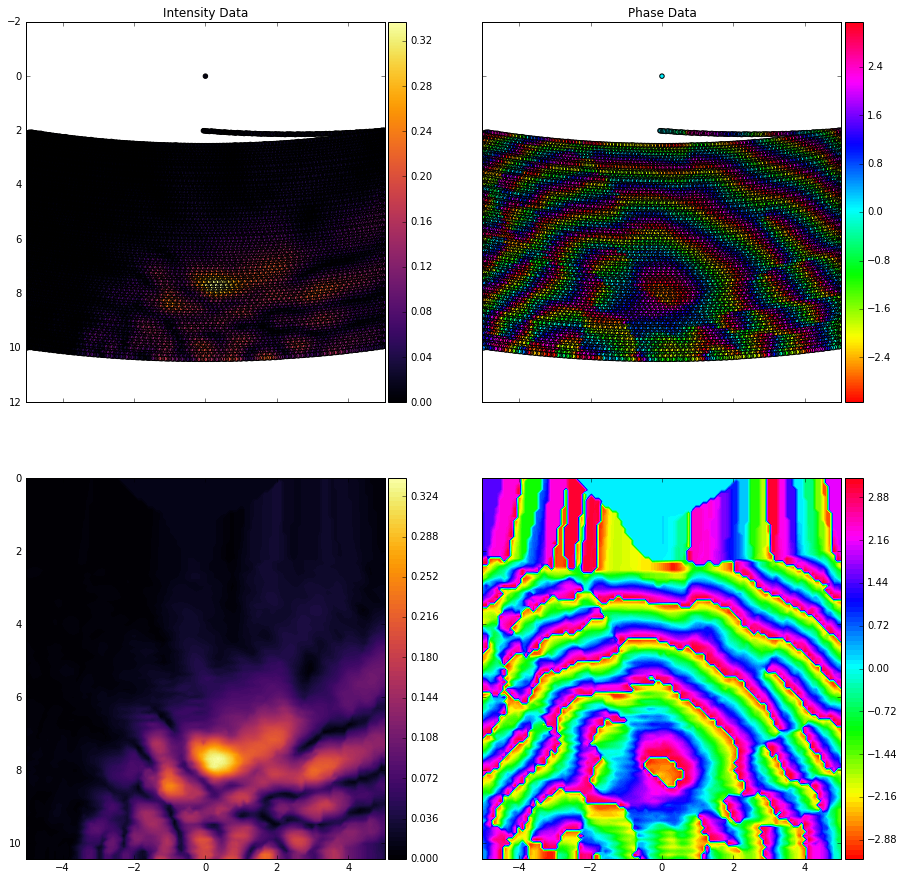

In [392]:
"""
Acoustic camera interface
"""
import serial
import numpy as np
import time
from matplotlib import pyplot as plt
from qacam.processing.process import saveData, plotData

#from find_devices import *


class stepper_motors(object):
    """
    Control stepper motors through serial interface
    Hardware: Arduino UNO
          Adafruit MotorShield version 2.3
          Two stepper motors connected to MotorShield
          USB connection to Arduino
    """

    def __init__(self, baudrate=9600, read_timeout=10): 
        """
        Initialize the serial connection to the Arduino board
        """
        port = '/dev/ttyACM0'
        try:
            self.arduino = serial.Serial(port=port,
                                         baudrate=baudrate,
                                         timeout=read_timeout)
            time.sleep(3)
            self.arduino.flush()
            
        except:
            print 'Could not find Arduino'
        self._speed = 10
        # XXX make it so

    def __del__(self):
        self.release()
        self.arduino.close()

    def command(self, cmd):
        cmds = cmd + '\n'
        self.arduino.write(cmds)
        #time.sleep(.1)
        self.arduino.flush()

    def goto(self, n1, n2):
        """
        Sends command G:n1:n2
        """
        cmd = 'G:%d:%d' % (n1, n2) #I changed it from M to G
        self.command(cmd)
        return

    def speed(self, s):
        """
        Sends speed V:s 
        """
        cmd='V:%d' % s 
        self.command(cmd)
        self._speed = s

    def release(self):
        """
        Stop and release motors.
        """
        self.command('S')

    def position(self):
        """
        Returns position of motors
        """
        self.command('P')

        line_received = self.arduino.readline().decode().strip()
        
        try:
            header, n1, n2 = line_received.split(':')
        except:
            print line_received
            n1 = 0
            n2 = 0
        return int(n1), int(n2)

    def are_running(self):
        """
        Returns True if motors are running
        """
        self.command('R')
        line_received = self.arduino.readline().decode().strip()


        try:
            header, running = line_received.split(':')
        except:
            print line_received
            running = 0
        return bool(int(running))
    


class polargraph(object):
    """
    Models stepper-based polargraph
    """

    def __init__(self, L=24.5, h=10., ds=0.02):
        self.motors = stepper_motors()
        self.L = float(L)
        self.h = float(h)
        self.ds = float(ds)
        self.s0 = np.sqrt((self.L / 2.)**2 + (self.h)**2)

    def goto(self, x, y, block=False):
        """
        Take the number of steps needed to reach coordinate (x,y)
        """

        s1 = np.sqrt((self.L / 2. - x)**2 + (y + self.h)**2)
        s2 = np.sqrt((self.L / 2. + x)**2 + (y + self.h)**2)
        n1 = np.rint((s1 - self.s0) / self.ds).astype(int)
        n2 = np.rint((self.s0 - s2) / self.ds).astype(int)
        self.motors.goto(n1, n2)
        if block:
            while self.is_running():
                time.sleep(0.1)  # wait 0.1 sec

    def home(self, block=True):
        """
        Go to home position
        """
        self.goto(0, 0, block=block)
        
    def position(self, cartesian=False):
        """
        Return the motors' current positions (in steps)
        """
        n1, n2 = self.motors.position()
        if (cartesian):
            s1 = self.s0 + n1*self.ds
            s2 = self.s0 - n2*self.ds
            x = (s2**2 - s1**2)/(2. * self.L)
            y = np.sqrt((s1**2 + s2**2)/2. - self.L**2/4. - x**2) - self.h
            return x, y
        else:
            return n1, n2

    def speed(self, s):
        """
        Set motor speed
        """
        self.motors.speed(s)

    def release(self):
        """
        Remove power from motors to prevent overheating
        """
        self.motors.release()

    def is_running(self):
        """
        Return TRUE if at least one of the motors is running
        """
        return self.motors.are_running()


class lock_in(object):
    """
    Models lock-in amplifier
    """

    def __init__(self, baudrate=9600,read_timeout=10):
        """
        Initialize RS-232 connection to lock-in
        """
        port = '/dev/ttyUSB0'
        try:
            self.port = serial.Serial(port=port, baudrate=baudrate,timeout=read_timeout)
        except:
            print 'Could not find lock-in'
        self.port = serial.Serial(port=port, baudrate=baudrate,timeout=read_timeout)
        self.data = ''
        self.eol = '\r'
        self.default_settings()
        


    def __del__(self):
        self.port.close()

    def write(self, cmd):
        """
        Write a CR-terminated string to the lock-in
        """
        self.port.write(cmd + self.eol)
        self.port.flush()

    def readln(self):
        """
        Read a string from the lock-in
        """
        self.data = ''
        c = self.port.read(1)
        while (c != self.eol):
            self.data += c
            c = self.port.read(1)
        return self.data

    def command(self, cmd):
        """
        Send a command to the lock-in and return the response
        """
        self.write(cmd)
        return self.readln()

    def default_settings(self):
        """
        Lock-in settings for the acoustic camera
        """
        self.write('*CLS')       # clear status registers
        self.write('FMOD 0')     # external reference source
        self.write('HARM 1')     # first harmonic
        self.write('ISRC 0')     # input A
        self.write('IGND 1')     # ground input shielding
        self.write('ICPL 0')     # AC input coupling
        self.write('ILIN 2')     # both line filters on input
        self.write('SENS 26')    # 1 V/uA (Previous was SENS 19;5mV/nA sensitivity)
        self.write('RMOD 1')     # reserve mode (normal)
        self.write('OFLT 7')     # time constant: 30 ms
        self.write('OFSL 1')     # low pass filter slope 12 dB/oct
        self.write('SYNC 0')     # no synchronous filter
        self.write('DDEF 1,1,0')  # Channel 1: R (no ratio)
        self.write('DDEF 2,1,0')  # Channel 2: theta (no ratio)
        # self.write('AGAN') # auto gain
        # self.write('ARSV') # auto reserve
        # self.write('APHS') # auto phase
        self.error = self.command('ERRS?')

    def output(self):
        """
        Return real and imaginary parts of measurement
        Instruction syntax:
        OUTP ? i
        i = 1: X
        i = 2: Y
        i = 3: R
        i = 4: theta
        SNAP?3,4
        """
        line_received = self.command('SNAP?3,4')
        try:
            R, theta = line_received.split(',')
        except:
            print 'ERROR:', line_received
            theta = 0.
            R = -1.
        theta = float(theta) * np.pi/180.
        R = float(R)
        p = R * np.exp(1j * theta)
        return p.real, p.imag
    

class acoustic_camera(object):
    """
    Models acoustic camera
    """

    def __init__(self):
        """
        Initialize RS-232 connection to polargraph and lock-in
        """
        self.polargraph = polargraph()
        self.lockin = lock_in()

    def goto(self, x, y, block=True):
        """
        Move microphone to desired position
        """
        self.polargraph.goto(x, y, block=block)

    def speed(self, s):
        """
        Set motor speed
        """
        self.polargraph.speed(s)

    def home(self):
        """
        Go to home position
        """
        self.polargraph.home()

    def is_running(self):
        """
        Returns true if polargraph is moving
        """
        return self.polargraph.is_running()

    def position(self):
        """
        Current position of polargraph
        """
        return self.polargraph.position()

    def read(self):
        """
        return polargraph position and lockin reading
        """
        return np.concatenate((self.polargraph.position(cartesian=True),
                               self.lockin.output()))

    def release(self):
        """
        power down polargraph motors
        """
        self.polargraph.release()

    def scan_to(self, x, y):
        """
        record data along line from present position to target position
        """
        data = list()
        data.append(self.read())
        self.goto(x, y, block=False)
        while self.is_running():
            data.append(self.read())
        data.append(self.read())
        return data

    def scan(self, scan_range, x0 = None, y0 = None, step=.1, vertical=False, scan= True):
        """
        record data along serpentine scan path included in the comments. Current vertical = False makes the 
        """
        #scan_range: 2-entry array of [xRange,yRange]
        h = self.polargraph.h
        if x0 is None:
            x0 = -scan_range[0]/2.
        if y0 is None:
            y0 = 0

        data = list()
        

        if scan == False: 
            self.home()
            self.release()
            return np.asarray(data)
        if vertical == True:
            ya, yb = y0, y0+scan_range[1]
            for x in np.arange(x0, x0 + scan_range[0]+1, step):
                self.goto(x, ya)
                thisline = self.scan_to(x, yb)
                data += thisline
                ya, yb = yb, ya
        else:
            xa, xb = x0, x0+scan_range[0]
            for y in np.linspace(y0, y0 + scan_range[1], scan_range[1]/step):
                self.goto(xa, y)
                thisline = self.scan_to(xb, y)
                data += thisline
                xa, xb = xb, xa
        self.goto(0,y0)
        self.release()
        return np.asarray(data)


if __name__ == "__main__":
    acam = acoustic_camera()
    li = lock_in()
    sm = stepper_motors()
    
    acam.speed(25)
    data = acam.scan([10,8],y0=2)
    acam.release()
    
    currentData = saveData(data)
    plotData(data,100,intensityScale='sqrt')

In [109]:
np.sqrt(acam.read()[2]**2+acam.read()[3]**2)

R:1


0.08966802397363345

In [ ]:
from qacam.processing.process import plotData
plotData(data,60)

In [387]:
acam.speed(100)
acam.goto(0,4)

P:273:-530


In [384]:
acam.position()

(273, -530)

In [374]:
acam.release()

0.0
14.601301282210393


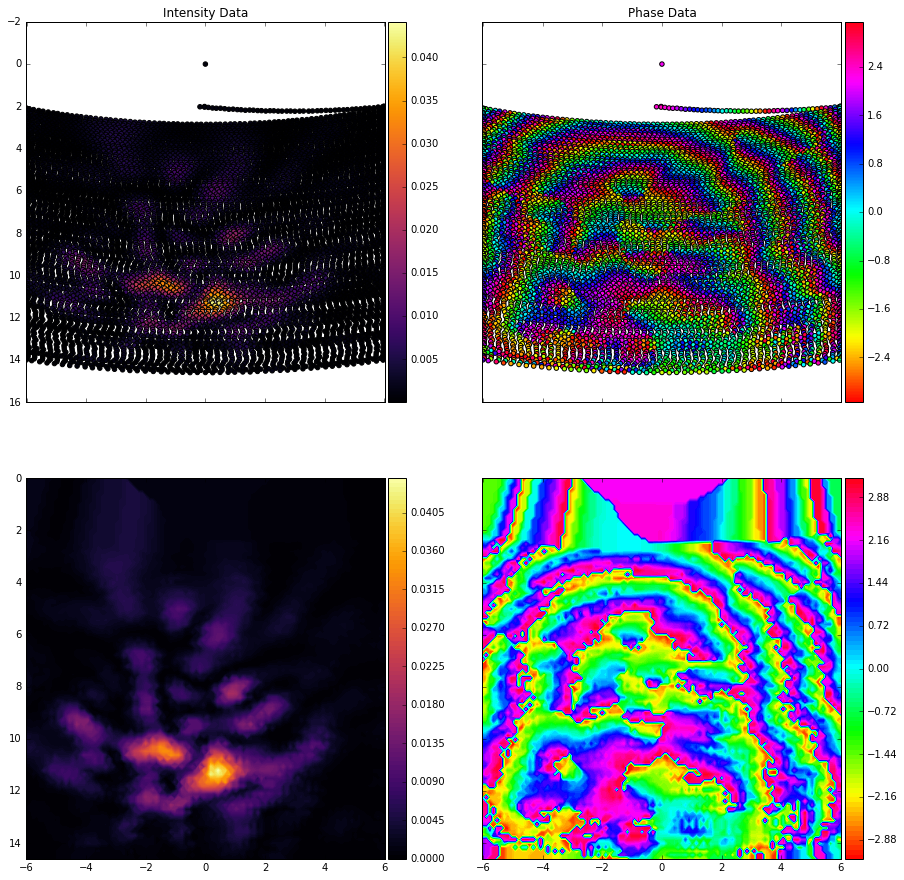

In [251]:
plotData(data,100,intensityScale='linear')

In [348]:
acam.home()

V
